In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
warnings.filterwarnings("ignore")
from gurobipy import *
plt.style.use('ggplot')

In [34]:
covid = pd.read_csv("owid-covid-data.csv")
germany = covid[covid['location'] == 'Germany']
start_date = '2021-09-24'
end_date = '2022-05-01'
germany = germany[(germany.date >= start_date) & (germany.date < end_date)]
N = len(germany)
T = 3
date = np.stack([germany.date.iloc[T*i+T-1] for i in range(int(N/T))])

In [35]:
hosp_admission = np.stack([np.mean(germany.weekly_hosp_admissions_per_million.iloc[T*i:T*(i+1)]) for i in range(int(N/T))])
cases = np.stack([np.mean(germany.new_cases_smoothed_per_million.iloc[T*i:T*(i+1)]) for i in range(int(N/T))])
str_index = np.stack([np.mean(germany.stringency_index.iloc[T*i:T*(i+1)]) for i in range(int(N/T))])
rt = np.stack([np.mean(germany.reproduction_rate.iloc[T*i:T*(i+1)]) for i in range(int(N/T))])
pos_rate = np.stack([np.mean(germany.positive_rate.iloc[T*i:T*(i+1)]) for i in range(int(N/T))])
total_vac = np.stack([np.mean(germany.people_fully_vaccinated_per_hundred.iloc[T*i:T*(i+1)]) for i in range(int(N/T))])
booster = np.stack([np.mean(germany.total_boosters_per_hundred.iloc[T*i:T*(i+1)]) for i in range(int(N/T))])

one_week_cases = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_cases[i] = cases[i-int(7/T)]
    
one_week_str_index = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_str_index[i] = str_index[i-int(7/T)]
    
one_week_rt = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_rt[i] = rt[i-int(7/T)]
    
one_week_pos_rate = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_pos_rate[i] = pos_rate[i-int(7/T)]
    
one_week_total_vac = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_total_vac[i] = total_vac[i-int(7/T)]
    
one_week_booster = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_booster[i] = booster[i-int(7/T)]

In [36]:
new_germany = pd.DataFrame()
new_germany['date'] = date
new_germany['hosp_admission'] = hosp_admission
#new_germany['one_week_cases'] = one_week_cases
#new_germany.one_week_cases = new_germany.one_week_cases.fillna(method='backfill')
new_germany['log_one_week_cases'] = np.log(one_week_cases)
new_germany.log_one_week_cases = new_germany.log_one_week_cases.fillna(method='backfill')
new_germany['str_index'] = str_index
new_germany['one_week_str_index'] = one_week_str_index
new_germany['one_week_total_vac'] = one_week_total_vac
new_germany['one_week_rt'] = one_week_rt
new_germany['one_week_pos_rate'] = one_week_pos_rate
new_germany['one_week_total_vac'] = one_week_total_vac
new_germany['one_week_total_vac'] = new_germany['one_week_total_vac'].fillna(0)
new_germany['one_week_booster'] = one_week_booster

In [37]:
mobility_2021 = pd.read_csv("2021_DE_Region_Mobility_Report.csv")
mobility_2021 = mobility_2021[mobility_2021.date >= start_date]
dates_2021 = sorted(list(set(mobility_2021.date)))
mobility_2021 = mobility_2021.iloc[:len(dates_2021),:]
mobility_2022 = pd.read_csv("2022_DE_Region_Mobility_Report.csv")
mobility_2022 = mobility_2022[mobility_2022.date < end_date]
dates_2022 = sorted(list(set(mobility_2022.date)))
mobility_2022 = mobility_2022.iloc[:len(dates_2022),:]


In [38]:
retail_and_recreation = []
grocery_and_pharmacy = []
parks = []
workplaces = []
residential = []
transit = []
for date in dates_2021:
    retail_and_recreation.append(int(mobility_2021[mobility_2021.date == date].retail_and_recreation_percent_change_from_baseline))
    grocery_and_pharmacy.append(int(mobility_2021[mobility_2021.date == date].grocery_and_pharmacy_percent_change_from_baseline))
    parks.append(int(mobility_2021[mobility_2021.date == date].parks_percent_change_from_baseline))
    workplaces.append(int(mobility_2021[mobility_2021.date == date].workplaces_percent_change_from_baseline))
    residential.append(int(mobility_2021[mobility_2021.date == date].residential_percent_change_from_baseline))
    transit.append(int(mobility_2021[mobility_2021.date == date].transit_stations_percent_change_from_baseline))

In [39]:
for date in dates_2022:
    retail_and_recreation.append(int(mobility_2022[mobility_2022.date == date].retail_and_recreation_percent_change_from_baseline))
    grocery_and_pharmacy.append(int(mobility_2022[mobility_2022.date == date].grocery_and_pharmacy_percent_change_from_baseline))
    parks.append(int(mobility_2022[mobility_2022.date == date].parks_percent_change_from_baseline))
    workplaces.append(int(mobility_2022[mobility_2022.date == date].workplaces_percent_change_from_baseline))
    residential.append(int(mobility_2022[mobility_2022.date == date].residential_percent_change_from_baseline))
    transit.append(int(mobility_2022[mobility_2022.date == date].transit_stations_percent_change_from_baseline))

In [40]:
one_week_retail_rec = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_retail_rec[i] = np.mean(retail_and_recreation[i-int(7/T):i])

one_week_grocery_pharmacy = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_grocery_pharmacy[i] = np.mean(grocery_and_pharmacy[i-int(7/T):])

one_week_parks = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_parks[i] = np.mean(parks[i-int(7/T):i])
    
one_week_workplaces = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_workplaces[i] = np.mean(workplaces[i-int(7/T):i])

one_week_residential = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_residential[i] = np.mean(residential[i-int(7/T):i])
    
one_week_transit = np.zeros(int(N/T))
for i in range(int(7/T),int(N/T)):
    one_week_transit[i] = np.mean(transit[i-int(7/T):i])

In [41]:
new_germany['one_week_retail_rec'] = one_week_retail_rec
new_germany['one_week_grocery_pharmacy'] = one_week_grocery_pharmacy
new_germany['one_week_parks'] = one_week_parks
new_germany['one_week_workplaces'] = one_week_workplaces
new_germany['one_week_residential'] = one_week_residential
new_germany['one_week_transit'] = one_week_transit

In [42]:
def MAE(sales, forecast):
    error = sales - forecast
    return np.mean(np.abs(error))
def MAPE(sales, forecast):
    error = sales - forecast
    return np.mean(np.abs(error / sales))
def RMSE(sales, forecast):
    error = sales - forecast
    return np.sqrt(np.mean(np.square(error)))

In [49]:
training_set = new_germany.iloc[int(7/T):int(0.7*N/T)]
test_set = new_germany.iloc[int(0.7*N/T):]

In [58]:
x_train = training_set.iloc[:,2:]
y_train = training_set.iloc[:,1]
x_test = test_set.iloc[:,2:]
y_test = test_set.iloc[:,1]

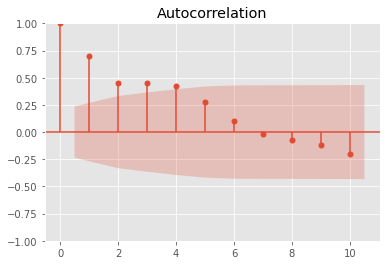

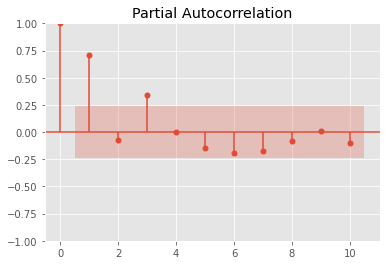

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
y_train_diff = np.array([y_train.iloc[i]-y_train.iloc[i-1] for i in range(1,len(y_train))])
y_test_diff = np.array([y_test.iloc[i]-y_test.iloc[i-1] for i in range(1,len(y_test))])
plot_acf(np.concatenate((y_train_diff,y_test_diff)), lags=10)
plot_pacf(np.concatenate((y_train_diff,y_test_diff)), lags=10)
plt.show()

In [69]:
arima1 = sm.tsa.statespace.SARIMAX(y_train_diff, trend ='c', order=(1,1,0),seasonal_order=(0, 0, 0, 0)).fit(disp=False)
print("MAE: {:.5f}".format(MAE(arima1.predict(len(y_train_diff),len(y_train_diff)+len(y_test_diff)-1), y_test_diff)))
print("MAPE: {:.5f}".format(MAPE(arima1.predict(len(y_train_diff),len(y_train_diff)+len(y_test_diff)-1), y_test_diff)))
print("RMSE: {:.5f}".format(RMSE(arima1.predict(len(y_train_diff),len(y_train_diff)+len(y_test_diff)-1), y_test_diff)))

MAE: 6.77624
MAPE: 4.76766
RMSE: 7.96574


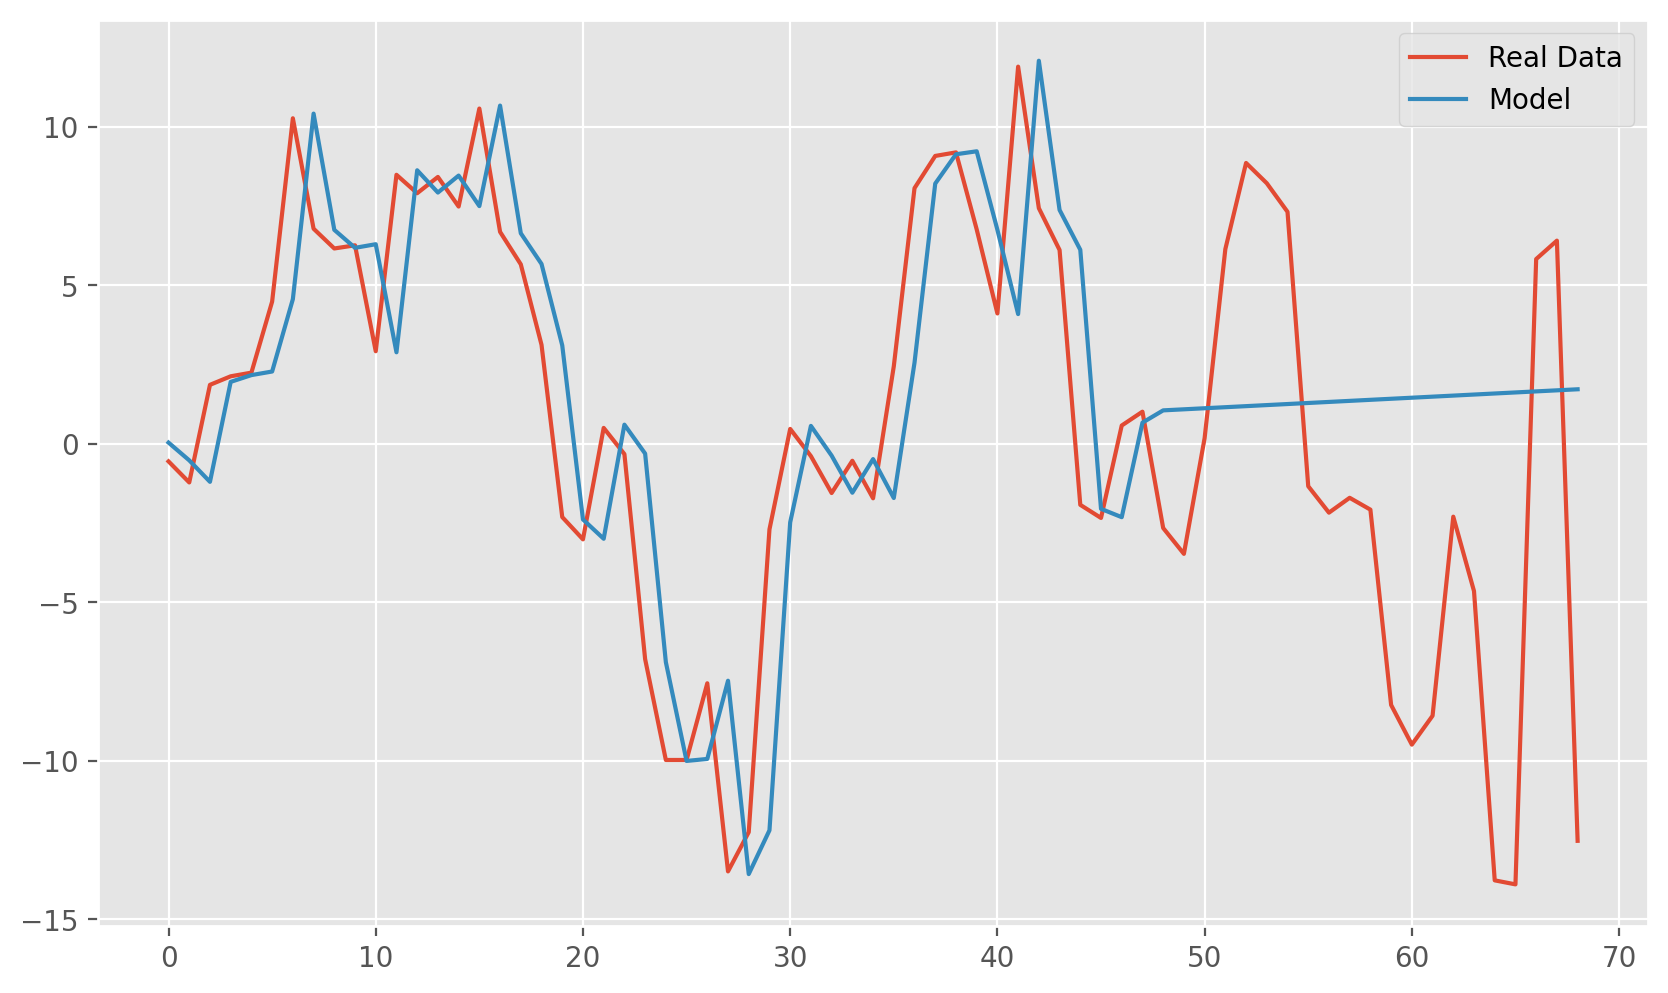

In [73]:
fig, ax = plt.subplots(figsize= (10,6), dpi = 200)
ax.plot(np.concatenate((y_train_diff, y_test_diff)), label = "Real Data")
ax.plot(arima1.predict(0,len(y_train_diff)+len(y_test_diff)-1), label = "Model")
ax.legend()
plt.show()

In [13]:
lasso = Lasso(normalize=True) 
lasso.set_params(alpha = 0.2)
lasso.fit(x_train, y_train)   
coefs = lasso.coef_ 
print([elem for elem in x_train.columns[list(np.where(coefs != 0)[0])]])
x_train_red = x_train.iloc[:,list(np.where(coefs != 0)[0])]
x_test_red = x_test.iloc[:,list(np.where(coefs != 0)[0])]
x_train_red = sm.add_constant(x_train_red)
x_test_red = sm.add_constant(x_test_red)
reg_model = sm.OLS(y_train, x_train_red)
results = reg_model.fit()
results.summary()

['log_one_week_cases', 'str_index', 'one_week_rt', 'one_week_booster', 'one_week_parks']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hosp_admission   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     127.4
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           3.68e-11
Time:                        13:54:07   Log-Likelihood:                -59.024
No. Observations:                  20   AIC:                             130.0
Df Residuals:                      14   BIC:                             136.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -201.0377     15.790    -12.732      0.000    -234.904    -167.171
log_one_week_cases    47.4188      3.029     15.657      0.000      40.923      53.915
str_index              0.3399      0.162      2.099      0.054      -0.007       0.687
one_week_rt           20.0709      7.791      2.576      0.022       3.360      36.782
one_week_booster      -1.4642      0.111    -13.248      0.000      -1.701      -1.227
one_week_parks        -0.1087      0.056     -1.939      0.073      -0.229       0.012
==============================================================================
Omnibus:                        0.122   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.085
Skew:                           0.095   Prob(JB):                        0.959
Kurtosis:                       2.745   Cond. No.                     1.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
print(RMSE(results.predict(x_train_red), y_train))
print(RMSE(results.predict(x_test_red), y_test))

4.628725562081308
17.490285790702163


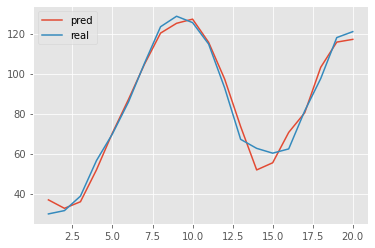

In [15]:
plt.plot(results.predict(x_train_red), label = "pred")
plt.plot(y_train, label = "real")
plt.legend()
plt.show()

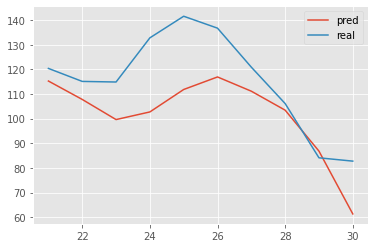

In [16]:
plt.plot(results.predict(x_test_red), label = "pred")
plt.plot(y_test, label = "real")
plt.legend()
plt.show()

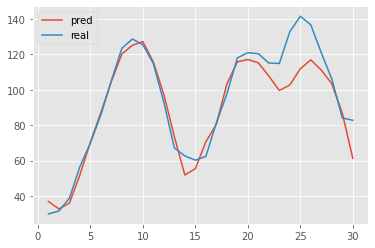

In [17]:
plt.plot(results.predict(pd.concat([x_train_red, x_test_red])), label = "pred")
plt.plot(pd.concat([y_train, y_test]), label = "real")
plt.legend()
plt.show()

In [18]:
def random_forest(max_features, x_train, y_train, x_test, y_test):
    random_forest = RandomForestRegressor(random_state=23, max_features=max_features)
    result = random_forest.fit(x_train, y_train)
    return result,RMSE(result.predict(x_train), y_train), RMSE(result.predict(x_test), y_test)

In [19]:
min_error = float('inf')
training_error = float('inf')
random_forest_model = None
features_star = None
for max_features in range(2,len(x_train.columns)+1):
    result, train_error, test_error = random_forest(max_features, x_train, y_train, x_test, y_test)
    if test_error < min_error:
        features_star = max_features
        random_forest_model = result
        training_error = train_error
        min_error = test_error

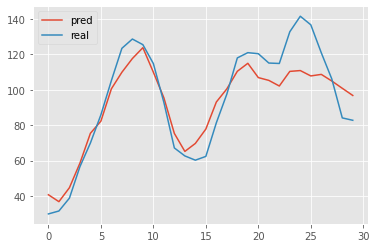

12
7.416667994077847
18.288729046969568


In [20]:
plt.plot(range(len(new_germany)-1),random_forest_model.predict(pd.concat([x_train, x_test])), label = "pred")
plt.plot(range(len(new_germany)-1),pd.concat([y_train, y_test]), label = "real")
plt.legend()
plt.show()
print(features_star)
print(train_error)
print(min_error)

Index(['log_one_week_cases', 'one_week_grocery_pharmacy', 'one_week_pos_rate',
       'one_week_rt'],
      dtype='object')


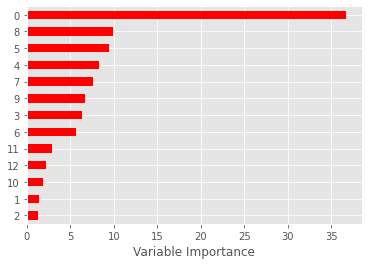

In [21]:
Importance = pd.DataFrame({'Importance':random_forest_model.feature_importances_*100}, 
                          )

Importance = Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True)

Importance.plot(kind = 'barh', 
                color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
print(x_train.columns[[0,8,5,4]])

In [22]:
def regression_tree(depth, x_train, y_train, x_test, y_test):
    regression_tree = DecisionTreeRegressor(random_state = 23, max_depth=depth)
    result = regression_tree.fit(x_train, y_train)
    return result, RMSE(result.predict(x_train), y_train), RMSE(result.predict(x_test), y_test)

In [23]:
min_error = float('inf')
min_error_train = float('inf')
regression_tree_model = None
depth_star = None
for depth in [2,3,4,5,8,9,10,11,12,15,20,30]:
    result, train_error, test_error = regression_tree(depth, x_train, y_train, x_test, y_test)
    if test_error < min_error:
        min_error_train = train_error
        depth_star = depth
        min_error = test_error
        regression_tree_model = result

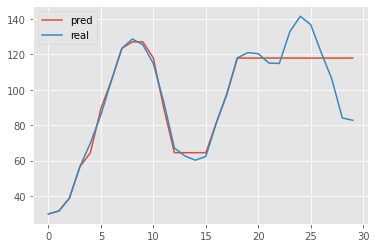

4
2.3627932912357865
19.192075978260632


In [24]:
plt.plot(range(len(new_germany)-1),regression_tree_model.predict(pd.concat([x_train, x_test])), label = "pred")
plt.plot(range(len(new_germany)-1),pd.concat([y_train, y_test]), label = "real")
plt.legend()
plt.show()
print(depth_star)
print(min_error_train)
print(min_error)

Index(['one_week_total_vac', 'log_one_week_cases', 'one_week_retail_rec',
       'one_week_rt'],
      dtype='object')


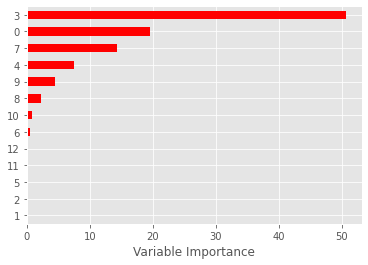

In [25]:
Importance = pd.DataFrame({'Importance':regression_tree_model.feature_importances_*100}, 
                          )

Importance = Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True)

Importance.plot(kind = 'barh', 
                color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
print(x_train.columns[[3,0,7,4]])

In [26]:
def boosted_tree(depth, lr, x_train, y_train, x_test, y_test):
    boosted_tree = GradientBoostingRegressor(learning_rate=lr, max_depth=depth, random_state = 23)
    result = boosted_tree.fit(x_train, y_train)
    return result, RMSE(result.predict(x_train), y_train), RMSE(result.predict(x_test), y_test)

In [27]:
min_error = float('inf')
min_error_train = float('inf')
boosted_tree_model = None
lr_opt = None
depth_opt = None
for lr in [0.1*i for i in range(1,11)]:
    for depth in np.linspace(1,30,30):
        result, train_error, test_error = boosted_tree(depth, lr, x_train, y_train, x_test, y_test)
        if test_error < min_error:
            lr_opt = lr
            depth_opt = depth
            min_error_train = train_error
            min_error = test_error
            boosted_tree_model = result

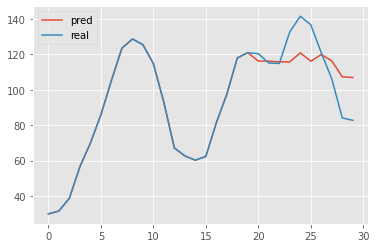

3.0
0.30000000000000004
2.4362094703580234e-07
15.455034918717631


In [28]:
plt.plot(range(len(new_germany)-1),boosted_tree_model.predict(pd.concat([x_train, x_test])), label = "pred")
plt.plot(range(len(new_germany)-1),pd.concat([y_train, y_test]), label = "real")
plt.legend()
plt.show()
print(depth_opt)
print(lr_opt)
print(min_error_train)
print(min_error)

Index(['one_week_total_vac', 'log_one_week_cases', 'one_week_rt',
       'one_week_grocery_pharmacy'],
      dtype='object')


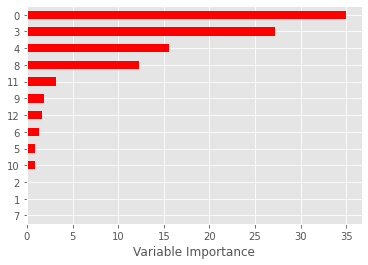

In [29]:
Importance = pd.DataFrame({'Importance':boosted_tree_model.feature_importances_*100}, 
                          )

Importance = Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True)

Importance.plot(kind = 'barh', 
                color = 'r')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
print(x_train.columns[[3,0,4,8]])

In [30]:
n_tr = len(x_train_red)                                        # Number of months in training set
n_te = len(x_test_red)                                         # Number of months in test set

y_train_hat = results.predict(x_train_red)
y_test_hat = results.predict(x_test_red)

service_level = 0.95
c_u = 10                                                       # Underage cost 
c_o = (1-service_level)/service_level * c_u                    # Overage cost 
model1 = Model("OPTIMIZATION")                                 # define a name for our model
Q = model1.addVar(name="Optimal Order", lb=0)                  # define variable Q as optimal order 
Z_pos = model1.addVars(range(0,n_tr+n_te), name="Underage", lb=0)   # define variable for underage
Z_neg = model1.addVars(range(0,n_tr+n_te), name="Overage", lb=0)    # define variable for overage

Restricted license - for non-production use only - expires 2023-10-25


In [31]:
model1.addConstrs((Z_pos[t] >= pd.concat([y_train_hat, y_test_hat]).iloc[t] - Q for t in range(0,n_tr+n_te)), name='Underage Level')  # define constraint for Underage
model1.addConstrs((Z_neg[t] >= Q - pd.concat([y_train_hat, y_test_hat]).iloc[t] for t in range(0,n_tr+n_te)), name='Overage Level')   # define constraint for Overage

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [32]:
obj1 = (1/(n_tr+n_te)) * quicksum(c_u * Z_pos[t] + c_o * Z_neg[t] for t in range(0,n_tr+n_te))     # define objective function

model1.setObjective(obj1, GRB.MINIMIZE)                                                # define Minimization method

model1.optimize()

for v in model1.getVars():                   
    if v.X != 0:                                                                       # print non-zero variables
        print("%s %f" % (v.Varname, v.X))

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60 rows, 61 columns and 120 nonzeros
Model fingerprint: 0x0fb474df
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve time: 0.00s
Presolved: 60 rows, 61 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.689880e+03   0.000000e+00      0s
      30    1.9402044e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.940204363e+01
Optimal Order 125.141746
Underage[9] 2.077225
Overage[0] 88.262755
Overage[1] 92.486936
Overage[2] 89.194945
Overage[3] 73.250364
Overage[4] 54.736296
Overage[5] 37.998817
Overage[6] 20.396488
Overage[7] 4.901522
Overage[10] 9.502235
Overage[11] 27.853643
Overa

In [33]:
opt_order_1 = Q.X
opt_obj_1 = model1.getObjective()

print(f'Lasso Regression Optimal Order Quantity is: {opt_order_1}')

Lasso Regression Optimal Order Quantity is: 125.14174619607499


In [34]:
n_tr = len(x_train)                                        # Number of months in training set
n_te = len(x_test)                                         # Number of months in test set

y_train_hat = random_forest_model.predict(x_train)
y_test_hat = random_forest_model.predict(x_test)

service_level = 0.95
c_u = 10                                                       # Underage cost 
c_o = (1-service_level)/service_level * c_u                    # Overage cost 
model1 = Model("OPTIMIZATION")                                 # define a name for our model
Q = model1.addVar(name="Optimal Order", lb=0)                  # define variable Q as optimal order 
Z_pos = model1.addVars(range(0,n_tr+n_te), name="Underage", lb=0)   # define variable for underage
Z_neg = model1.addVars(range(0,n_tr+n_te), name="Overage", lb=0)    # define variable for overage

In [35]:
model1.addConstrs((Z_pos[t] >= np.concatenate((y_train_hat, y_test_hat))[t] - Q for t in range(0,n_tr+n_te)), name='Underage Level')  # define constraint for Underage
model1.addConstrs((Z_neg[t] >= Q - np.concatenate((y_train_hat, y_test_hat))[t] for t in range(0,n_tr+n_te)), name='Overage Level')   # define constraint for Overage

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [36]:
obj1 = (1/(n_tr+n_te)) * quicksum(c_u * Z_pos[t] + c_o * Z_neg[t] for t in range(0,n_tr+n_te))     # define objective function

model1.setObjective(obj1, GRB.MINIMIZE)                                                # define Minimization method

model1.optimize()

for v in model1.getVars():                   
    if v.X != 0:                                                                       # print non-zero variables
        print("%s %f" % (v.Varname, v.X))
        
opt_order_1 = Q.X
opt_obj_1 = model1.getObjective()

print(f'Random Forest Optimal Order Quantity is: {opt_order_1}')

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60 rows, 61 columns and 120 nonzeros
Model fingerprint: 0x7b8cf74c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 1e+02]
Presolve time: 0.00s
Presolved: 60 rows, 61 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.757131e+03   0.000000e+00      0s
      30    1.5702413e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.570241328e+01
Optimal Order 117.644393
Underage[9] 6.141857
Overage[0] 76.962844
Overage[1] 80.870624
Overage[2] 72.990936
Overage[3] 59.145746
Overage[4] 42.243233
Overage[5] 35.368746
Overage[6] 17.096093
Overage[7] 7.757763
Overage[10] 7.737987
Overage[11] 22.166169
Overa

In [37]:
n_tr = len(x_train)                                        # Number of months in training set
n_te = len(x_test)                                         # Number of months in test set

y_train_hat = regression_tree_model.predict(x_train)
y_test_hat = regression_tree_model.predict(x_test)

service_level = 0.95
c_u = 10                                                       # Underage cost 
c_o = (1-service_level)/service_level * c_u                    # Overage cost 
model1 = Model("OPTIMIZATION")                                 # define a name for our model
Q = model1.addVar(name="Optimal Order", lb=0)                  # define variable Q as optimal order 
Z_pos = model1.addVars(range(0,n_tr+n_te), name="Underage", lb=0)   # define variable for underage
Z_neg = model1.addVars(range(0,n_tr+n_te), name="Overage", lb=0)    # define variable for overage

In [38]:
model1.addConstrs((Z_pos[t] >= np.concatenate((y_train_hat, y_test_hat))[t] - Q for t in range(0,n_tr+n_te)), name='Underage Level')  # define constraint for Underage
model1.addConstrs((Z_neg[t] >= Q - np.concatenate((y_train_hat, y_test_hat))[t] for t in range(0,n_tr+n_te)), name='Overage Level')   # define constraint for Overage

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [39]:
obj1 = (1/(n_tr+n_te)) * quicksum(c_u * Z_pos[t] + c_o * Z_neg[t] for t in range(0,n_tr+n_te))     # define objective function

model1.setObjective(obj1, GRB.MINIMIZE)                                                # define Minimization method

model1.optimize()

for v in model1.getVars():                   
    if v.X != 0:                                                                       # print non-zero variables
        print("%s %f" % (v.Varname, v.X))
        
opt_order_1 = Q.X
opt_obj_1 = model1.getObjective()

print(f'Regression Tree Optimal Order Quantity is: {opt_order_1}')

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60 rows, 61 columns and 120 nonzeros
Model fingerprint: 0x08094086
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve time: 0.00s
Presolved: 60 rows, 61 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.852223e+03   0.000000e+00      0s
      30    1.6843480e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.684347953e+01
Optimal Order 127.076714
Overage[0] 97.221571
Overage[1] 95.566571
Overage[2] 88.313000
Overage[3] 70.555857
Overage[4] 62.628943
Overage[5] 37.715643
Overage[6] 21.870429
Overage[7] 3.655000
Overage[10] 9.158619
Overage[11] 37.715643
Overage[12] 62.628943
Over

In [40]:
n_tr = len(x_train)                                        # Number of months in training set
n_te = len(x_test)                                         # Number of months in test set

y_train_hat = boosted_tree_model.predict(x_train)
y_test_hat = boosted_tree_model.predict(x_test)

service_level = 0.95
c_u = 10                                                       # Underage cost 
c_o = (1-service_level)/service_level * c_u                    # Overage cost 
model1 = Model("OPTIMIZATION")                                 # define a name for our model
Q = model1.addVar(name="Optimal Order", lb=0)                  # define variable Q as optimal order 
Z_pos = model1.addVars(range(0,n_tr+n_te), name="Underage", lb=0)   # define variable for underage
Z_neg = model1.addVars(range(0,n_tr+n_te), name="Overage", lb=0)    # define variable for overage

In [41]:
model1.addConstrs((Z_pos[t] >= np.concatenate((y_train_hat, y_test_hat))[t] - Q for t in range(0,n_tr+n_te)), name='Underage Level')  # define constraint for Underage
model1.addConstrs((Z_neg[t] >= Q - np.concatenate((y_train_hat, y_test_hat))[t] for t in range(0,n_tr+n_te)), name='Overage Level')   # define constraint for Overage

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [42]:
obj1 = (1/(n_tr+n_te)) * quicksum(c_u * Z_pos[t] + c_o * Z_neg[t] for t in range(0,n_tr+n_te))     # define objective function

model1.setObjective(obj1, GRB.MINIMIZE)                                                # define Minimization method

model1.optimize()

for v in model1.getVars():                   
    if v.X != 0:                                                                       # print non-zero variables
        print("%s %f" % (v.Varname, v.X))
        
opt_order_1 = Q.X
opt_obj_1 = model1.getObjective()

print(f'Boosted Tree Optimal Order Quantity is: {opt_order_1}')

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 60 rows, 61 columns and 120 nonzeros
Model fingerprint: 0x3c0d9418
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve time: 0.00s
Presolved: 60 rows, 61 columns, 120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.824537e+03   0.000000e+00      0s
      30    1.7608617e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.760861685e+01
Optimal Order 125.484000
Underage[8] 3.185429
Overage[0] 95.628857
Overage[1] 93.973857
Overage[2] 86.720285
Overage[3] 68.963143
Overage[4] 55.571143
Overage[5] 39.642429
Overage[6] 20.277714
Overage[7] 2.062286
Overage[10] 10.705000
Overage[11] 32.603428
Over